In [1]:
import pathlib, sys, os, random, time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# mounting google drive
collaboratory = False

if collaboratory:
    from google.colab import drive
    drive.mount('/gdrive')
    # !ln -s "/gdrive/Shareddrives/HSC_project/HSC_ML" "/content/HSC_ML"
    os.chdir("/gdrive/Shareddrives/HSC_project/HSC_ML")
else: 
    print('Running on local systems, if running on collaboratory please change above')

print(os.listdir())
# print(os.getcwd())
#!unzip ./HSC_ML/Output/TBCells_crops.zip -d ./HSC_ML/Output/

if collaboratory:
  image_folder = "./Output/"
else:
  image_folder = "../../Output/TBCells_crops/Train_data/"
trained_weights = image_folder[:-11]+"Results/Latest_Weight_AE/"


if not os.path.exists(trained_weights):
        os.makedirs(trained_weights)

Running on local systems, if running on collaboratory please change above
['Note.txt', 'test copy.ipynb', 'CNN_training.ipynb', 'CNN_auto_encoder.ipynb', 'delete-files.py', 'Resnet_training.ipynb', 'CNN_training_test.ipynb', 'CNN_auto_encoder_backup.ipynb']


# Elastic deformation

In [3]:

# pip install git+https://github.com/gvtulder/elasticdeform

import numpy, imageio, elasticdeform
from matplotlib import image

augmented_data_req = False

if augmented_data_req:
    augmented_images = os.path.abspath(os.path.join(image_folder, os.pardir)) + "/augmented_images/"

    if not os.path.exists(augmented_images):
            os.makedirs(augmented_images)
            

    for folder in os.listdir(image_folder):
        current_folder = os.path.join(image_folder, folder)
        augmented_folder = augmented_images + folder + "/"
        
        if not os.path.exists(augmented_folder):
            os.makedirs(augmented_folder)
        for image_name in os.listdir(current_folder):
            current_image = os.path.join(current_folder,  image_name)
            # apply deformation with a random 3 x 3 grid
            my_image = np.array(image.imread(current_image))
            images_deformed = elasticdeform.deform_random_grid(my_image, sigma=3, points=2)
            imageio.imsave( augmented_folder + image_name.split(".")[0] + "_aug.tif", images_deformed)
    



In [4]:
# copy generated images

copy_augmented_data = False
if copy_augmented_data:
    import shutil
    for folder in os.listdir(image_folder):
        current_folder = os.path.join(image_folder, folder)
        augmented_folder = augmented_images + folder + "/"
        for image_name in os.listdir(augmented_folder):
            current_image = os.path.join(augmented_folder,  image_name)
            shutil.copy(current_image, current_folder)

# spliting dataset into train and test

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ColorJitter(brightness = 0.25, contrast=0.25),
    #transforms.RandomRotation(90),
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor()])

In [6]:
import torch
from torchvision import datasets

# add path of images https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [7]:
import sklearn.model_selection


dataset = ImageFolderWithPaths(image_folder, transform=train_transform)
print(dataset.class_to_idx)
train_indices, val_indices = sklearn.model_selection.train_test_split(
                    list(range(dataset.__len__())),          # list of indices of dataset
                    stratify = dataset.targets,                 # for stratify sampling the data due to the unblanced dataset
                    random_state = 42,
                    test_size=.25                               #represent the proportion of the dataset to include in the train split.
                    )



# subsetting the dataset into train and test
training_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, val_indices) 

print(f"Length of dataset:" )
print(f" {'Train dataset':<12}   \u2502   {'Test data':>12} ")
print(f" {len(training_data):<12}    \u2502   {len(test_data) :>12}")



{'BCells_Old_crops': 0, 'TCells_Old_crops': 1}
Length of dataset:
 Train dataset   │      Test data 
 49116           │          16372


# Iterating and Visualizing the Dataset

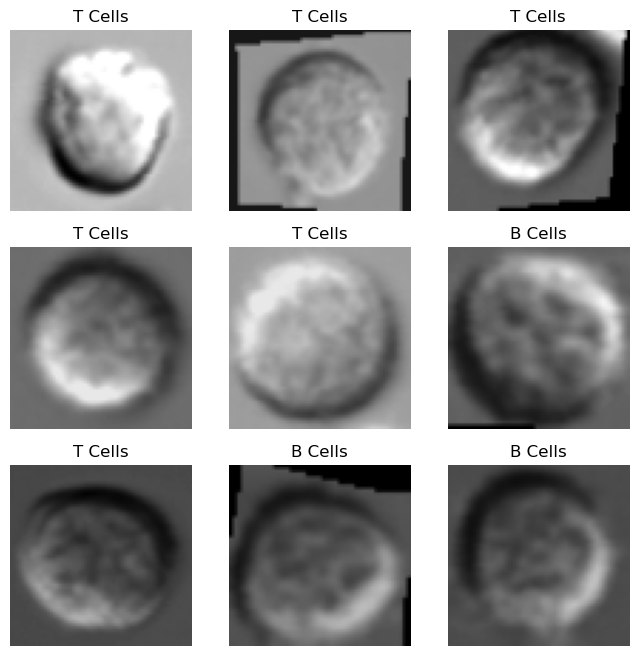

In [8]:
labels_map = {
    0: "B Cells",
    1: "T Cells",
    #2: "T8 Cells",

}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray") 
plt.show()

In [9]:

batch_size = 64

# setting sampler weight
y_train_indices = training_data.indices
y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) 


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size= batch_size,sampler = sampler, pin_memory=True, )
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y, _ in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 64, 64])
Shape of y:  torch.Size([64]) torch.int64


# Training the model

In [10]:
def enc_block(in_features, out_features, kernel_size=3, padding=1):
            """ run 1 block of convolution  
            
            """
            block = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=3, padding=1),
                nn.LeakyReLU(),
                nn.BatchNorm2d(out_features),
                
            )
            # mx_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
            return block
        
def dec_block(in_features, out_features, kernel_size=3, padding=1):
            """ run 1 block of convolution  
            
            """
            block = nn.Sequential(
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, padding=1),
                nn.LeakyReLU(),
                nn.BatchNorm2d(out_features),
                
            )
            # mx_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
            return block
        
def print_shape(block_type, x):
    return print(f' {block_type} with shape: {x.size()}')

In [11]:
class CNN_encoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        
        self.encoder_1 = enc_block(in_features, 16, kernel_size=3, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_2 = enc_block(16, 32, kernel_size=3, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_3 = enc_block(32, 64, kernel_size=3, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_lin = nn.Sequential(   
            nn.Flatten(start_dim=1, ),
            #each Maxpool make the images into half. 
            # so after the Maxpool image size become 64 ==> 32 ==>16 ==> 8
            nn.Linear(8*8*64, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
 

    def forward(self, x):
        x            = self.encoder_1(x)
        x, indices_1 = self.encoder_pool1(x)
        x            = self.encoder_2(x)
        x, indices_2 = self.encoder_pool2(x)
        x            = self.encoder_3(x)
        x, indices_3 = self.encoder_pool3(x)
        x            = self.encoder_lin(x)
        return x, indices_1, indices_2, indices_3



class CNN_decoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(n_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 8*8*64),
            nn.ReLU(),
            nn.Unflatten(1, unflattened_size= (64, 8, 8))
        )
        
        self.mx_pool_1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_1 = dec_block(64, 32, kernel_size=3, padding=1)
        
        self.mx_pool_2 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_2 = dec_block(32, 16, kernel_size=3, padding=1)
        
        self.mx_pool_3 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_3 = dec_block(16, in_features, kernel_size=3, padding=1)
        
        


    def forward(self, x, indices_1, indices_2, indices_3):

        x  = self.decoder_lin(x)
        x  = self.mx_pool_1 (x,  indices_3)
        x  = self.decoder_1(x)
        x  = self.mx_pool_2 (x,  indices_2)
        x  = self.decoder_2(x)
        x  = self.mx_pool_3 (x,  indices_1)
        x  = self.decoder_3(x)
        return x
    
    
    
class CNN_AE(nn.Module):
    
    def __init__(self, in_channels=3, n_classes=50, *args, **kwargs):
        super().__init__()
        self.encoder = CNN_encoder(in_channels, n_classes = 50, *args, **kwargs)
        self.decoder = CNN_decoder(in_channels, n_classes = 50, *args, **kwargs)
        
    def forward(self, x):
        x, indices_1, indices_2, indices_3 = self.encoder(x)
        x = self.decoder(x, indices_1, indices_2, indices_3)
        return x

In [12]:
# defining the model

import torchvision.models as models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Cuda acceleration enabled!" if torch.cuda.is_available() else 'Running on CPU')


def get_model():
    # initializing with resnet weight
    #model = models.resnet50(weights="IMAGENET1K_V2")
    model = CNN_AE()

    # # get the input feature in fully connected layer
    # num_in_features = model.fc.in_features

    # # Replace the final fully connected layer to suite the problem
    # model.fc = nn.Sequential(nn.Linear(num_in_features, 512),
    #                                 nn.ReLU(),
    #                                 nn.Dropout(0.3),
    #                                 nn.Linear(512, 128),
    #                                 nn.Linear(128, 32),
    #                                 nn.Linear(32, len(labels_map)))
    
    # using gpu
    model = model.cuda() if torch.cuda.is_available() else model
    # print(model)
    return model


@torch.no_grad()
def validation(model, train_dataloader, loss_fn):
    losses = []
    model.eval()
    for image, target, _ in train_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()


def loss_fn(y_pred, y_true):
    bce_fn = nn.CrossEntropyLoss()
    loss = bce_fn(y_pred, y_true)
    return loss


### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}' + '\t' + '\u2502 {}'


Cuda acceleration enabled!


In [13]:
# loading the model

model = get_model()

model.to(DEVICE)

# # not optimizing the whole network for now
# # optimizer = torch.optim.AdamW(model.parameters(),
# #                   lr=1e-4, weight_decay=1e-3)

# ignored_params = list(map(id, model.fc.parameters()))
# base_params = filter(lambda p: id(p) not in ignored_params,
#                      model.parameters())

learning_rate = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000001)

# Reconstruct model from saved weights

In [14]:
restart = False
if restart:
    model1 = torchvision.models.resnet50()
    model1.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=2048,
            out_features=1
        ),
        torch.nn.Sigmoid()
    )
    model1.load_state_dict(torch.load(trained_weights +'TBCells.pt'))

# Evaluating results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

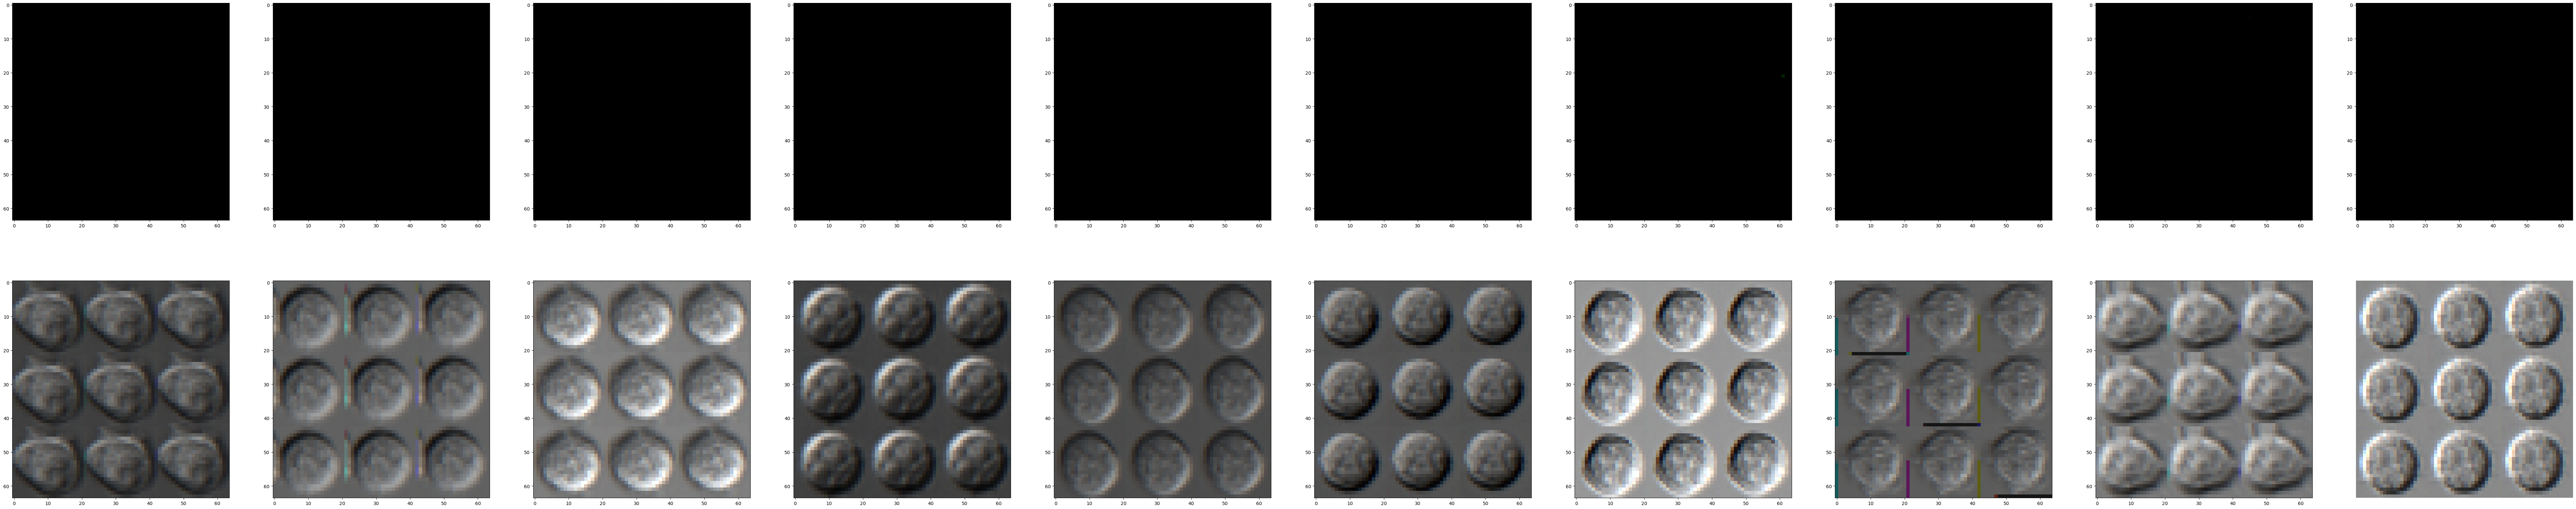

In [15]:

# validating dataset

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import shutil

# defining hook to access output from intermidiate layer
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# registerning the hook. different layer can be accessed by changing
# fc[3] parameter. for details 
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html
# model.decoder[4].register_forward_hook(get_features('feats'))


trained_model_PATH = trained_weights +'TBCells.pt'
model.load_state_dict(torch.load(trained_model_PATH))
model.eval()
#print(model)

y_pred = []
y_true = []
FEATS = [] # extracted feats will be saved here
# placeholder for batch features
features = {}

outputs_dict = {}

# Extracting the last batch from the test
# dataset
img_list = []
out_list = []
with torch.no_grad():
    for image, target, path in test_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        outputs = model(image)
        outputs_dict['img'] = image
        outputs_dict['out'] = outputs

counter = 1
val = outputs_dict['out'].cpu().detach().numpy()

# Plotting first 10 images of the batch
fig, axs = plt.subplots(2, 10, figsize=(100, 20))

val = outputs_dict['out'].cpu().detach().numpy()
# Loop over the subplots and plot data on each one
for i, ax in enumerate(axs.flat[:10]):
    ax.imshow(val[i].reshape(64, 64,3), cmap='gray')
    plt.axis('off') 

val = outputs_dict['img'].cpu().detach().numpy()

for i, ax in enumerate(axs.flat[10:]):
    ax.imshow(val[i].reshape(64, 64,3), cmap='gray')
    plt.axis('off') 
# Show the plot
plt.show()


/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


average acuraccy of all classes: nan


ValueError: zero-size array to reduction operation fmin which has no identity

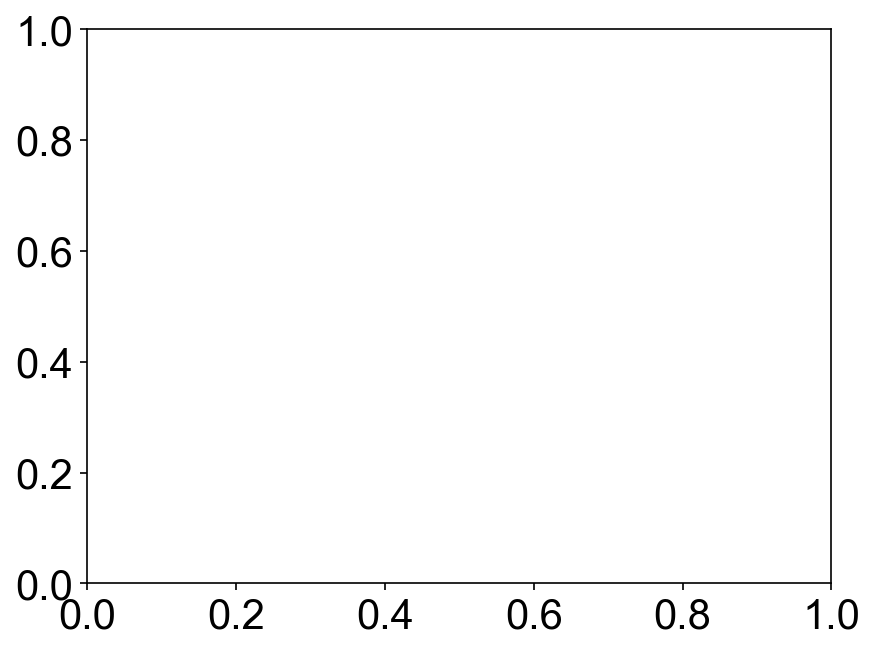

In [16]:
classes = labels_map.values()   
 
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

class_accuracy=np.mean(100*cf_matrix.diagonal()/cf_matrix.sum(1))
print(f'average acuraccy of all classes: {class_accuracy}')

# ploting 
font = {'family' : 'Arial',
        'size'   : 20}

plt.rc('font', **font)
fig, ax = plt.subplots( dpi = 150)
sn.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')
ax.set_title(f'Confusion Matrix, average acuracy: {class_accuracy :.2f}', fontsize = 15)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.xlabel('Predicted'); plt.ylabel('True');

plt.savefig(trained_weights + 'cf_matrix.png', bbox_inches='tight')

In [ ]:
# classification report

from sklearn.metrics import classification_report
import seaborn as sns

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(cls_report)
# df.drop(columns=['accuracy'])

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.heatmap(df.iloc[:-1, :].T, annot=True)
fig.tight_layout()
plt.savefig(trained_weights + "classification_report.png", bbox_inches='tight', dpi=150)

In [ ]:
# T-SNE plot

from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=0, perplexity=50, n_iter= 5000)
tsne_proj = tsne.fit_transform(FEATS)
# Plot those points as a scatter plot and label them based on the pred labels

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for lab in range(len(labels_map)):
    indices = np.array(y_pred)==lab
    true_indices = np.array(y_true)==lab
    #ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = labels_map[lab] ,alpha=0.5)
    #ax.scatter(tsne_proj[true_indices,0],tsne_proj[true_indices,1], label = labels_map[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.savefig(trained_weights + "T-SNE.png", bbox_inches='tight', dpi=150)

In [ ]:
true_indices = np.array(y_pred) != np.array(y_true)
# print(len(true_indices==1))
print(true_indices)

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for lab in range(len(labels_map)):
    indices = np.array(y_pred)==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = labels_map[lab] ,alpha=0.1)
ax.scatter(tsne_proj[np.array(y_pred) != np.array(y_true) & y_true==1,0],tsne_proj[np.array(y_pred) != np.array(y_true),1] & 

           y_true==1, label = lab ,alpha=0.4)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [ ]:
#pip install keyboard
#import keyboard
#keyboard.press_and_release('command+s')

nb_name = "test.ipynb"
nb_full_path = os.path.join(os.getcwd(), nb_name)

import shutil
shutil.copyfile(nb_full_path, trained_weights  + nb_name)
